# Classification of oil and gas

## Описание задачи

Нефтегазовая отрасль имеет сложную технологическую цепочку, которая начинается с геологической разведки и заканчивается доставкой нефти и газа потребителям. Одной из важных задач является определение места залежей — на суше или в море — на основе различных параметров.

Задача: разработать алгоритм машинного обучения, который позволит классифицировать место залежей нефти и газа.

Данные. Набор данных содержит 442 сведений о различных нефтегазовых месторождениях.

- Field name - название месторождения
- Reservoir unit - юнит месторождения
- Country - страна расположения
- Region - регион расположения
- Basin name - название бассейна пород
- Tectonic regime - тектонический режим
- Latitude - широта
- Longitude - долгота
- Operator company - название компании
- Onshore or oﬀshore - целевая переменная (ONSHORE - 1, OFFSHORE - 0, ONSHORE-OFFSHORE - 2)
- Hydrocarbon type (main) - тип углеводорода
- Reservoir status (current) - статус месторождения
- Structural setting - структурные свойства
- Depth (top reservoir ft TVD) - глубина
- Reservoir period - литологический период
- Lithology (main) - литология
- Thickness (gross average ft) - общая толщина
- Thickness (net pay average ft) - эффективная толщина
- Porosity (matrix average 20. Permeability (air average mD) – проницаемость

![photo](photo.jpg)

In [3]:
# импорт необходимых библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import RandomOverSampler

### Исследование и анализ датасета

In [4]:
# Загрузка данных
df_train = pd.read_csv('train_oil.csv')
df_test = pd.read_csv('oil_test.csv')

df_train.head()

,Field name,Reservoir unit,Country,Region,Basin name,Tectonic regime,Latitude,Longitude,Operator company,Onshore/Offshore,Hydrocarbon type,Reservoir status,Structural setting,Depth,Reservoir period,Lithology,Thickness (gross average ft),Thickness (net pay average ft),Porosity,Permeability
0,ZHIRNOV,MELEKESKIAN,RUSSIA,FORMER SOVIET UNION,VOLGA-URAL,COMPRESSION/EVAPORITE,51.0000,44.8042,NIZHNEVOLZHSKNET,ONSHORE,OIL,DECLINING PRODUCTION,FORELAND,1870,CARBONIFEROUS,SANDSTONE,262.0,33.0,24.0,30.0
1,LAGOA PARDA,LAGOA PARDA (URUCUTUCA),BRAZIL,LATIN AMERICA,ESPIRITO SANTO,EXTENSION,-19.6017,-39.8332,PETROBRAS,ONSHORE,OIL,NEARLY DEPLETED,PASSIVE MARGIN,4843,PALEOGENE,SANDSTONE,2133.0,72.0,23.0,350.0
2,ABQAIQ,ARAB D,SAUDI ARABIA,MIDDLE EAST,THE GULF,COMPRESSION/EVAPORITE,26.0800,49.8100,SAUDI ARAMCO,ONSHORE,OIL,REJUVENATING,FORELAND,6050,JURASSIC,LIMESTONE,250.0,184.0,21.0,410.0
3,MURCHISON,BRENT,UK /NORWAY,EUROPE,NORTH SEA NORTHERN,EXTENSION,61.3833,1.7500,CNR,OFFSHORE,OIL,NEARLY DEPLETED,RIFT,8988,JURASSIC,SANDSTONE,425.0,300.0,22.0,750.0
4,WEST PEMBINA,NISKU (PEMBINA L POOL),CANADA,NORTH AMERICA,WESTERN CANADA,COMPRESSION,53.2287,-115.8008,NUMEROUS,ONSHORE,OIL,UNKNOWN,FORELAND,9306,DEVONIAN,DOLOMITE,233.0,167.0,11.8,1407.0


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Field name                      309 non-null    object 
 1   Reservoir unit                  309 non-null    object 
 2   Country                         282 non-null    object 
 3   Region                          271 non-null    object 
 4   Basin name                      271 non-null    object 
 5   Tectonic regime                 309 non-null    object 
 6   Latitude                        282 non-null    float64
 7   Longitude                       279 non-null    float64
 8   Operator company                309 non-null    object 
 9   Onshore/Offshore                309 non-null    object 
 10  Hydrocarbon type                309 non-null    object 
 11  Reservoir status                309 non-null    object 
 12  Structural setting              309 

In [6]:
# проверка на пропуски
missing = ((df_train.isna().sum() * 100)/df_train.shape[0] ).sort_values()
missing[missing > 0]


Latitude       8.737864
Country        8.737864
Longitude      9.708738
Basin name    12.297735
Region        12.297735
dtype: float64

Вывод: в данных присутсвуют пропуски. Полностью удалять эти строки не буду. Применю импутацию. 

In [7]:
# проверка на дубли
df_train.duplicated().sum(), df_test.duplicated().sum()

(np.int64(0), np.int64(0))

In [8]:
# проверяем целевую переменную на дисбаланс классрв
y_counts = df_train['Onshore/Offshore'].value_counts()
y_cnt = (y_counts / y_counts.sum()) * 100
print(y_counts, y_cnt)

Onshore/Offshore
ONSHORE             218
OFFSHORE             86
ONSHORE-OFFSHORE      5
Name: count, dtype: int64 Onshore/Offshore
ONSHORE             70.550162
OFFSHORE            27.831715
ONSHORE-OFFSHORE     1.618123
Name: count, dtype: float64


<BarContainer object of 3 artists>

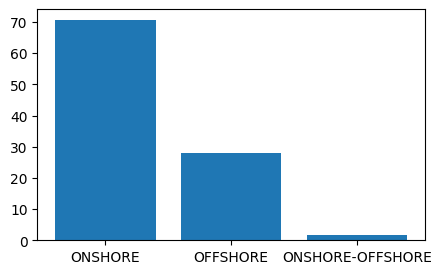

In [9]:
plt.figure(figsize=(5,3))
plt.bar(y_cnt.index, y_cnt.values)

Вывод: присутсвует дисбаланс классов. Самый редкий класс ONSHORE-OFFSHORE удалю.

In [10]:
# разделю признаки и целевую переменную
X = df_train.drop(columns = ['Onshore/Offshore'])
y = df_train['Onshore/Offshore']

# запишу в отдельные переменные название колонок категориальных и числвых признаков

num = X.select_dtypes(include = [np.number]).columns
cat = X.select_dtypes(exclude = [np.number]).columns

In [11]:
# Статистика по числовым признакам
X[num].describe()

,Latitude,Longitude,Depth,Thickness (gross average ft),Thickness (net pay average ft),Porosity,Permeability
count,282.00000,279.000000,309.000000,309.000000,309.000000,309.000000,309.000000
mean,35.62426,-12.508435,6755.669903,760.087379,183.683236,17.825178,476.994757
std,22.19116,86.387220,3628.094135,1353.934404,282.252489,7.171048,1000.140605
min,-38.39890,-151.615300,220.000000,11.000000,2.120000,1.100000,0.010000
25%,28.24915,-102.336500,4059.000000,128.000000,45.000000,12.000000,10.000000
50%,38.13500,1.810000,6500.000000,312.000000,110.000000,17.000000,68.000000
75%,52.13360,56.179900,9186.000000,715.000000,205.000000,23.600000,390.000000
max,76.44620,148.417000,19888.000000,8200.000000,2976.000000,35.000000,7500.000000


Вывод: присутсвую значения с большим разбросом и выбросами. Далее буду решать эту проблему путем масштабирования.

/var/folders/w3/7_qnv3gx3rd6bbs9rzsnvzjm0000gn/T/ipykernel_13795/236571620.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([X[c].dropna() for c in num[2:-2]], labels=num[2:-2], showfliers=True)


Text(0.5, 1.0, 'Boxplot числовых признаков')

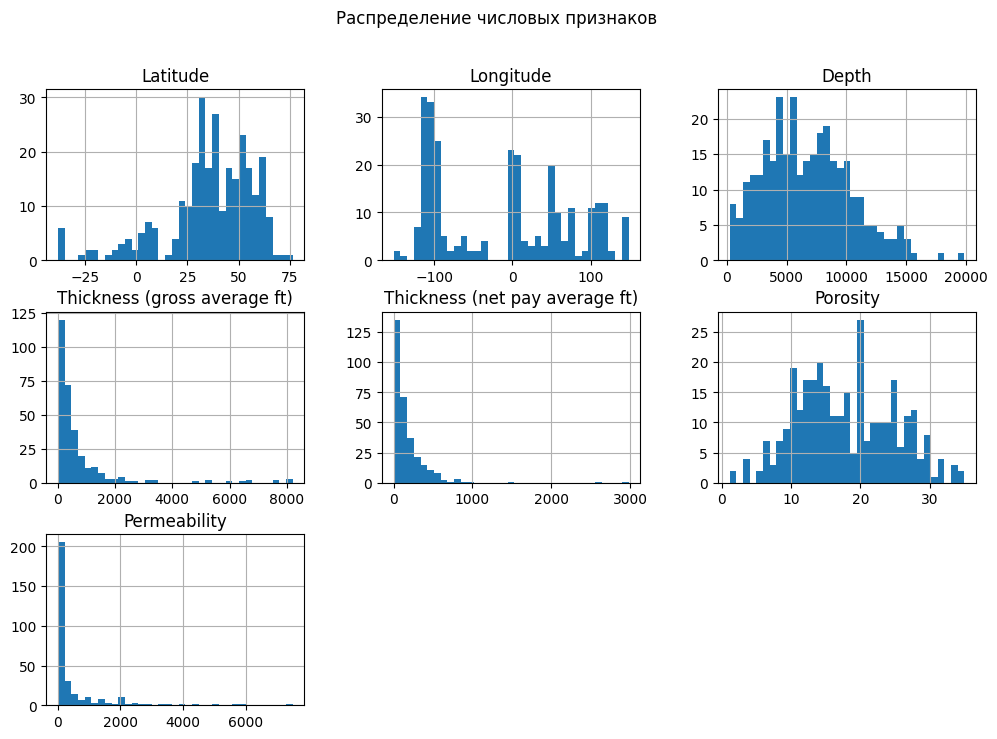

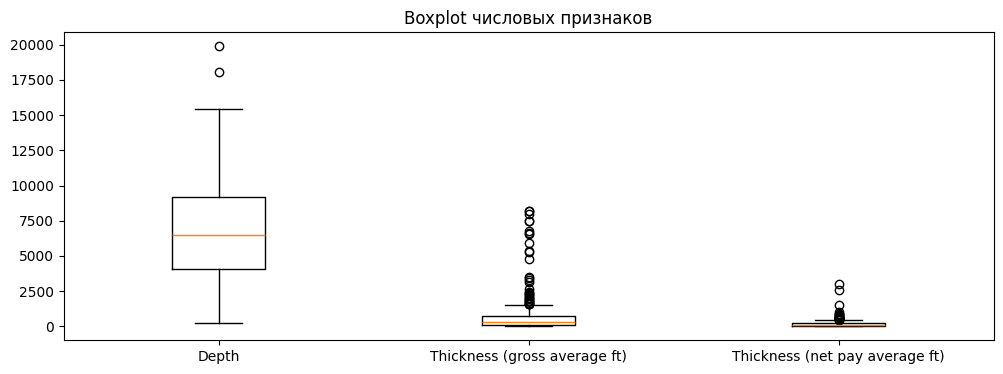

In [12]:
X[num].hist(figsize=(12,8), bins=35)
plt.suptitle('Распределение числовых признаков')

plt.figure(figsize=(12,4))
plt.boxplot([X[c].dropna() for c in num[2:-2]], labels=num[2:-2], showfliers=True)
plt.title('Boxplot числовых признаков')


In [13]:
# Корреляция числовых признаков
corr = X[num].corr()
corr


,Latitude,Longitude,Depth,Thickness (gross average ft),Thickness (net pay average ft),Porosity,Permeability
Latitude,1.000000,-0.323446,0.137568,-0.060014,-0.038955,-0.177277,-0.159048
Longitude,-0.323446,1.000000,-0.095084,0.210117,0.156536,0.261563,0.151979
Depth,0.137568,-0.095084,1.000000,-0.008981,0.159343,-0.399428,-0.229735
Thickness (gross average ft),-0.060014,0.210117,-0.008981,1.000000,0.493691,-0.030386,-0.091860
Thickness (net pay average ft),-0.038955,0.156536,0.159343,0.493691,1.000000,-0.070752,-0.063283
Porosity,-0.177277,0.261563,-0.399428,-0.030386,-0.070752,1.000000,0.489377
Permeability,-0.159048,0.151979,-0.229735,-0.091860,-0.063283,0.489377,1.000000


Вывод: Сильных корреляций между признаками нет. Присутсвует умеренная корреляция между некоторыми признаками.

In [14]:
# Проверим категориальные признаки на уникальность 
uniq = X[cat].nunique().sort_values()
uniq

Hydrocarbon type        4
Region                  7
Reservoir status       13
Lithology              13
Reservoir period       22
Country                42
Structural setting     43
Tectonic regime        55
Basin name             93
Operator company      138
Reservoir unit        258
Field name            285
dtype: int64

Вывод: есть признаки с очень высоким количеством уникальных значений. Далее удалим их, так как нецелособразно применять OneHotEncoder

##### Общий вывод: 
##### Датасет 309 строк, 20 колонок,целевой признак Onshore/Offshore, категориальных признаков 13,числовых 7.Есть пропуски в Country, Region, Basin name, Latitude, Longitude, остальные - заполнены/ Целевая переменная несбалансирована. Числовые признаки имеют выбросы и скошенные распределения (Depth, Thickness, Permeability), поэтому на этапе предобработки понадобится масштабирование. По корреляциям - нет сильной мультиколлинеарности.

### Предобработка данных. Feature Engineering.


In [15]:
# Обработка пропусков
# c учетом анализа данных произведенного выше
# числовые пропуски заполню медианой 
# категориальные часто повторяющееся значение 
med = df_train[num].median()
modes = df_train[cat].mode().iloc[0]

df_train[num] = df_train[num].fillna(med)
df_train[cat] = df_train[cat].fillna(modes)

df_test[num] = df_test[num].fillna(med)
df_test[cat] = df_test[cat].fillna(modes)

In [16]:
# удалю категориальные признаки с высоким количеством уникальных значений
df_train = df_train.drop(columns=['Field name', 'Reservoir unit', 'Operator company'])
df_test = df_test.drop(columns=['Field name', 'Reservoir unit', 'Operator company'])

In [17]:
# кодирование целевой переменной
df_train = df_train[df_train['Onshore/Offshore'] != 'ONSHORE-OFFSHORE']
y = df_train['Onshore/Offshore'].map({'OFFSHORE': 0, 'ONSHORE': 1}).astype(int)
X = df_train.drop(columns = 'Onshore/Offshore')

In [18]:
# Масштабирование 
scaler = StandardScaler()
df_train[num] = scaler.fit_transform(df_train[num])
df_test[num] = scaler.transform(df_test[num])

In [19]:
X['net_to_gross'] = X['Thickness (gross average ft)'] / X['Thickness (gross average ft)']
X['geo_radius'] = np.sqrt(X['Latitude']**2 + X['Longitude']**2)

df_test['net_to_gross'] = df_test['Thickness (gross average ft)'] / df_test['Thickness (gross average ft)']
df_test['geo_radius'] = np.sqrt(df_test['Latitude']**2 + df_test['Longitude']**2)


In [20]:
num = X.select_dtypes(include='number').columns
cat = X.select_dtypes(exclude=[np.number]).columns

In [21]:
# кодирование категориальных переменных
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_cat = ohe.fit_transform(X[cat])
df_test_cat = ohe.transform(df_test[cat])

cat_feature_names = ohe.get_feature_names_out(cat)
X_cat_df = pd.DataFrame(X_cat, columns=cat_feature_names, index=X.index)
test_cat_df = pd.DataFrame(df_test_cat, columns=cat_feature_names, index=df_test.index)

In [22]:
#финальные датафреймы
X_final= pd.concat([X.drop(columns=cat), X_cat_df], axis=1)
test_final = pd.concat([df_test.drop(columns=cat), test_cat_df], axis=1)

#### Вывод


##### В ходе предобработки устранила пропуски (Числовые медианой, категориальные - наиболее частым значением).Удаление признаков с очень большим числом уникальных значений (неподходят для OneHotEncoder). Упростили задачу до бинарной классификации. Подготовила данные для модели: масштабирование числовых признаков и кодирование категориальных. 

### Обучение нескольких моделей, их сравнение

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42, stratify=y
)


In [24]:
models = {
    'LogReg': LogisticRegression(max_iter=7500),
    'KNN': KNeighborsClassifier(n_neighbors=10),
    'DecisionTree': DecisionTreeClassifier(random_state=42)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    results.append({
        'model': name,
        'accuracy': accuracy_score(y_test, pred),
        'f1': f1_score(y_test, pred)
    })

results_df = pd.DataFrame(results)
results_df

/Users/Yuno/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,model,accuracy,f1
0,LogReg,0.819672,0.876404
1,KNN,0.737705,0.829787
2,DecisionTree,0.901639,0.933333


#### Вывод

Я сравнила три базовые модели по одинаковым метрикам. По метрике f1 наилучший результат показала модель дерева решений, что говорит о хорошем балансе precision и recall. 
Далее проведём подбор гиперпараметров, чтобы улучшить качество и проверить устойчивость модели. Дерево решений склонно к переобучению

### Подбор гиперпараметров

In [25]:
# подбор гиперпараметров для дерева решений
tree = DecisionTreeClassifier(random_state=42)
param_grid_tree = {
    'max_depth': [2,3,4,5,6,8,10, None],
    'min_samples_split': [2,5,10,20],
    'min_samples_leaf': [1,2,5,10],
    'criterion': ['gini', 'entropy']
}
g_tree = GridSearchCV(tree, param_grid_tree,scoring = 'f1', cv = 3, n_jobs=-1)
g_tree.fit(X_train, y_train)


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5, 6, 8, 10, None],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 5, 10, 20]},
             scoring='f1')

In [26]:
g_tree.best_params_, g_tree.best_score_

({'criterion': 'gini',
  'max_depth': 8,
  'min_samples_leaf': 1,
  'min_samples_split': 2},
 np.float64(0.8912209385251747))

In [27]:
# подбор гиперпараметров для логистической регрессии
logreg = LogisticRegression(max_iter=7500)

param_grid_lr = {
    'penalty':['l1','l2', None],
    'solver': ['liblinear', 'lbfgs','newton-cg'],
    'class_weight':['balanced', None],
    'C': np.arange(0.01, 1, 0.02)
}

g_lr = GridSearchCV(logreg, param_grid_lr, scoring='f1', cv=3, n_jobs=-1)
g_lr.fit(X_train, y_train)

/Users/Yuno/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/Yuno/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/Yuno/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/Yuno/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/Yuno/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/Yuno/Library/Python/3.9/lib/python/site-packages

GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=7500), n_jobs=-1,
             param_grid={'C': array([0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19, 0.21,
       0.23, 0.25, 0.27, 0.29, 0.31, 0.33, 0.35, 0.37, 0.39, 0.41, 0.43,
       0.45, 0.47, 0.49, 0.51, 0.53, 0.55, 0.57, 0.59, 0.61, 0.63, 0.65,
       0.67, 0.69, 0.71, 0.73, 0.75, 0.77, 0.79, 0.81, 0.83, 0.85, 0.87,
       0.89, 0.91, 0.93, 0.95, 0.97, 0.99]),
                         'class_weight': ['balanced', None],
                         'penalty': ['l1', 'l2', None],
                         'solver': ['liblinear', 'lbfgs', 'newton-cg',
                                    'newton-cholesky', 'saga']},
             scoring='f1')

In [28]:
g_lr.best_params_, g_lr.best_score_

({'C': np.float64(0.01),
  'class_weight': None,
  'penalty': None,
  'solver': 'newton-cg'},
 np.float64(0.915081134646352))

In [29]:
# подбор гиперпараметров для логистической регрессии
knn = KNeighborsClassifier()
param_grid_knn ={
    'n_neighbors': np.arange(3, 30, 2)
}
g_knn = GridSearchCV(knn, param_grid_knn, scoring = 'f1', cv = 3, n_jobs=-1)
g_knn.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': array([ 3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29])},
             scoring='f1')

In [30]:
g_knn.best_params_, g_knn.best_score_

({'n_neighbors': np.int64(19)}, np.float64(0.8459583671262503))

In [43]:
models = {
    'LogReg': LogisticRegression(C = 0.01, max_iter=7500,class_weight = 'balanced', solver='lbfgs'),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'DecisionTree': DecisionTreeClassifier(criterion='gini',max_depth = 8,min_samples_split = 2,  random_state=42)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    results.append({
        'model': name,
        'accuracy': accuracy_score(y_test, pred),
        'f1': f1_score(y_test, pred)
    })

results_df = pd.DataFrame(results)
results_df

,model,accuracy,f1
0,LogReg,0.754098,0.810127
1,KNN,0.704918,0.804348
2,DecisionTree,0.868852,0.913043


#### Вывод

Лучший результат по кросс-валидации показало дерево решений (0.891), значит на текущих фичах и после предобработки оно лучше всего отделяет классы

### Предсказание на тестовых данных

In [48]:
# Обучим модель полностью на тренировочных данных. И предскажем на тесте 
final_model = DecisionTreeClassifier(criterion='gini', max_depth=8, min_samples_split=2, random_state=42)
final_model.fit(X_final, y)

DecisionTreeClassifier(max_depth=8, random_state=42)

In [46]:
final_model = LogisticRegression(penalty=None, C = 0.01, max_iter=7000,solver = 'newton-cg')
final_model.fit(X_final, y)

/Users/Yuno/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


LogisticRegression(C=0.01, max_iter=7000, penalty=None, solver='newton-cg')

In [49]:
# проверим на трейне
pred_train = final_model.predict(X_final)
accuracy_score(y, pred_train), f1_score(y, pred_train)

(0.9572368421052632, 0.970917225950783)

In [41]:
pred_test = final_model.predict(test_final)

In [42]:
idx = df_test["index"] if "index" in df_test.columns else df_test.index

submission = pd.DataFrame({
    "index": idx,
    "Onshore/Offshore": pred_test
})

submission.to_csv("submission.csv", index=False)
submission.head()

,index,Onshore/Offshore
0,0,1
1,1,1
2,2,1
3,3,0
4,4,1


### Итоги


В ходе работы провела исследование датасета: проверила типы данных, пропуски и дубликаты, посмотрела распределение целевой переменной и выявила дисбаланс классов. Также проанализировала числовые признаки (описательная статистика, распределения, выбросы) и категориальные признаки (количество уникальных значений), после чего приняла решения по предобработке

Далее обучила несколько моделей (логистическая регрессия, KNN и дерево решений) и сравнила их по метрикам на валидационной выборке. По результатам сравнения дерево решений показало высокий результат на обучении, но сильно переобучалось и давало хуже качество на тесте, поэтому не выбрала его как финальное решение. (дерево решений давало точность на тесте около 66.8, что показалось мне недостаточно хорошим результатом)

В качестве финальной модели выбрала логистическую регрессию. Она показала наиболее стабильное качество на тестовойвыборке среди рассмотренных моделей, то есть лучше обобщала данные и была менее склонна к переобучению. После подбора гиперпараметров я дообучила модель на всем тренировочном датасете и получила предсказания для тестового набора.